# Data Preprocessing

In [37]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2
import os
import shutil
from random import sample


In [3]:
# Load data from npy
img = np.load('data_old/images.npy')
lbl = np.load('data_old/labels.npy')

In [ ]:
# Get both channels
classification_maps = lbl[:, :, :, 1]
segmentation_maps = lbl[:, :, :, 0]

In [ ]:
# Plot iamges and masks
def plot_img_label(img, lbl, img_title="image", lbl_title="label", **kwargs):
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    fig.colorbar(im, ax=ai)
    al.imshow(lbl)
    al.set_title(lbl_title)
    plt.tight_layout()

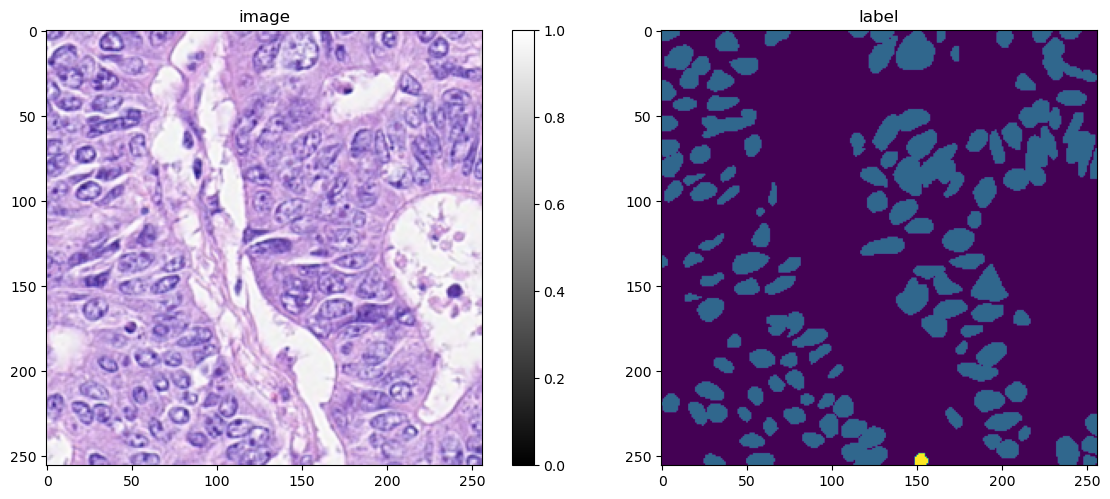

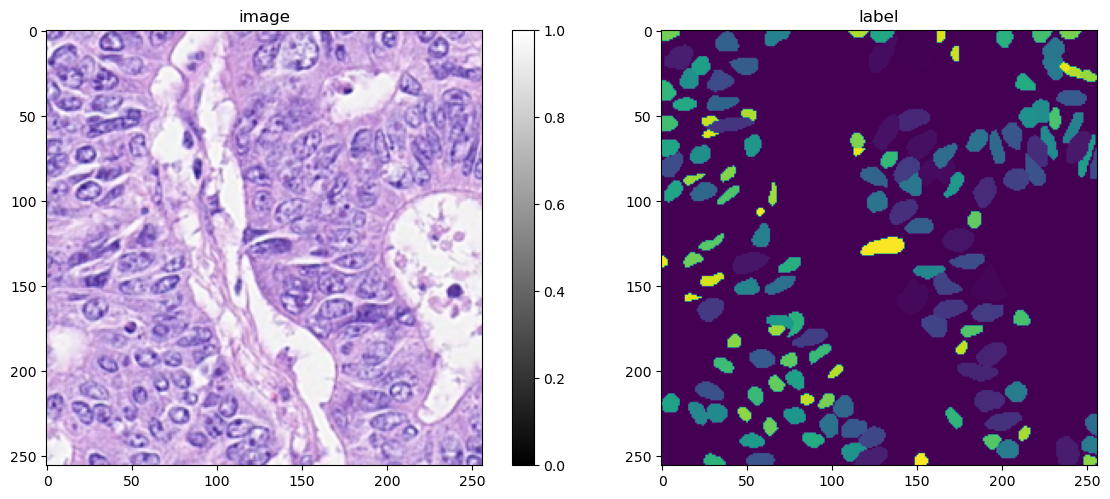

In [ ]:
# Sanity check
plot_img_label(img[0], classification_maps[0])
plot_img_label(img[0], segmentation_maps[0])

### Extract patches

In [ ]:
def extract_square_patches(segmentation_maps, classification_maps, images, margin=10, patch_size=(64, 64)):
    all_patches = []
    all_labels = []
    
    for i in range(len(images)):
        segmentation_map = segmentation_maps[i]
        classification_map = classification_maps[i]
        image = images[i]
        
        for cell_id in np.unique(segmentation_map):
            if cell_id == 0: # Skip background
                continue
            
            # Find the positions of the current cell
            positions = np.where(segmentation_map == cell_id)
            min_row, min_col = np.min(positions, axis=1)
            max_row, max_col = np.max(positions, axis=1)

            # Determine the size of the square bounding box
            box_size = max(max_row - min_row, max_col - min_col) + margin

            # Calculate the center of the bounding box
            center_row = (max_row + min_row) // 2
            center_col = (max_col + min_col) // 2

            # Determine new min and max rows and columns
            start_row = max(center_row - box_size // 2, 0)
            end_row = min(center_row + box_size // 2, segmentation_map.shape[0])
            start_col = max(center_col - box_size // 2, 0)
            end_col = min(center_col + box_size // 2, segmentation_map.shape[1])

            # Extract the patch from the image
            patch = image[start_row:end_row, start_col:end_col]
            
            # Resize the patch to the desired size
            resized_patch = cv2.resize(patch, patch_size, interpolation=cv2.INTER_LINEAR)
            
            # Extract the class labels using the classification map
            class_patch = classification_map[start_row:end_row, start_col:end_col]
            
            # Exclude background and find the majority class
            class_values = class_patch[class_patch > 0]
            if class_values.size > 0:
                majority_class = np.argmax(np.bincount(class_values))
            else:
                continue # Skip if no class information is present
            
            all_patches.append(resized_patch)
            all_labels.append(majority_class)

    return all_patches, all_labels

In [ ]:
# Get all patches and labels
patches, labels = extract_square_patches(segmentation_maps, classification_maps, img)

In [ ]:
# How many of each class
for i in range(1, 7):
    print(f"Class {i}: {labels.count(i)}")

Class 1: 5080
Class 2: 285535
Class 3: 118624
Class 4: 31773
Class 5: 3978
Class 6: 124871


In [ ]:
# Change to binary classification (class 1 vs all others)
binary_labels = [1 if label == 1 else 0 for label in labels]

# How many of each class
for i in range(2):
    print(f"Class {i}: {binary_labels.count(i)}")

Class 0: 564781
Class 1: 5080


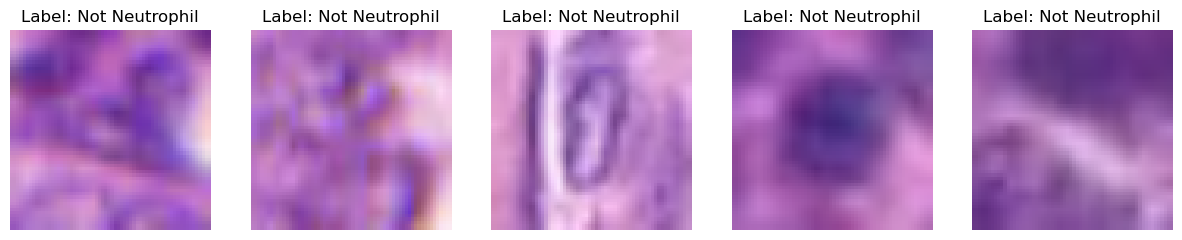

In [ ]:
# '1' corresponds to Neutrophil and other labels to different cell types
def get_cell_type_label(class_value):
    return 'Neutrophil' if class_value == 1 else 'Not Neutrophil'

# Plotting function
def plot_patches_with_labels(patches, labels, num_to_plot=5):
    plt.figure(figsize=(15, 3))
    for i in range(min(num_to_plot, len(patches))):
        plt.subplot(1, num_to_plot, i + 1)
        plt.imshow(patches[i])
        # Map the label to the appropriate cell type
        cell_type_label = get_cell_type_label(labels[i])
        plt.title(f'Label: {cell_type_label}')
        plt.axis('off')
    plt.show()

# Randomly select some patches to visualize
num_to_plot = 5
random_indices = np.random.choice(len(patches), num_to_plot, replace=False)
selected_patches = [patches[i] for i in random_indices]
selected_labels = [binary_labels[i] for i in random_indices]

plot_patches_with_labels(selected_patches, selected_labels, num_to_plot)

In [ ]:
# Define your directories for neutrophil and not_neutrophil
neutrophil_dir = 'data/neutrophil'
not_neutrophil_dir = 'data/not_neutrophil'

# Create directories if they don't exist
if not os.path.exists(neutrophil_dir):
    os.makedirs(neutrophil_dir)

if not os.path.exists(not_neutrophil_dir):
    os.makedirs(not_neutrophil_dir)

# Iterate through the patches and labels and save them in the respective directories
for i, (patch, label) in enumerate(zip(patches, labels)):
    # Convert patch to uint8 if it's not already
    patch_to_save = (patch * 255).astype(np.uint8) if patch.dtype == np.float64 else patch
    filename = f"patch_{i}.png"
    
    if label == 1:  # Neutrophil
        imageio.imwrite(os.path.join(neutrophil_dir, filename), patch_to_save)
    else:  # Not Neutrophil
        imageio.imwrite(os.path.join(not_neutrophil_dir, filename), patch_to_save)


In [38]:
# Move 10% of the data to to data/test/neutrophil and data/test/not_neutrophil with a 50/50 split
def move_images(src_folder, dest_folder, percentage=0.1):
    # Ensure destination folder exists
    os.makedirs(dest_folder, exist_ok=True)

    # List all files in the source folder
    files = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
    
    # Calculate number of files to move
    num_files_to_move = int(len(files) * percentage)

    # Randomly select files to move
    selected_files = sample(files, num_files_to_move)

    # Move selected files to destination folder
    for file in selected_files:
        shutil.move(os.path.join(src_folder, file), os.path.join(dest_folder, file))

# Define source and destination folders
neutrophil_src = 'data/neutrophil'
not_neutrophil_src = 'data/not_neutrophil'
neutrophil_dest = 'data/test/neutrophil'
not_neutrophil_dest = 'data/test/not_neutrophil'

# Move 10% of neutrophil and not_neutrophil images to test folders
move_images(neutrophil_src, neutrophil_dest, 0.1)
move_images(not_neutrophil_src, not_neutrophil_dest, 0.1)

# Training Setup

In [21]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning import Trainer
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from torchvision import datasets, transforms, models
from prodigyopt import Prodigy

In [39]:
class ImageClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.model = models.resnet34(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)
        self.criterion = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        # Configure optimizers and learning rate schedulers
        optimizer = Prodigy(self.parameters(), lr=1.)
        return optimizer

In [40]:
class ImageDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='data/train', batch_size=32, num_classes=None, val_split=0.2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.val_split = val_split
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def setup(self, stage=None):
        # Load the full dataset
        full_dataset = datasets.ImageFolder(root=self.data_dir, transform=self.transform)
        
        # Calculate weights for each class in the full dataset
        class_counts = torch.tensor([len([img for img, label in full_dataset.samples if label == class_id]) for class_id in range(len(full_dataset.classes))])
        class_weights = 1. / class_counts
        sample_weights = torch.tensor([class_weights[label] for _, label in full_dataset.samples])

        # Split the dataset
        val_size = int(len(full_dataset) * self.val_split)
        train_size = len(full_dataset) - val_size
        self.train_dataset, self.val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
        
        # Apply the sampler only to the training set
        train_indices = self.train_dataset.indices
        train_weights = sample_weights[train_indices]
        self.sampler = WeightedRandomSampler(weights=train_weights, num_samples=len(train_weights), replacement=True)

    def train_dataloader(self):
        # Use the sampler here
        return DataLoader(self.train_dataset, batch_size=self.batch_size, sampler=self.sampler)

    def val_dataloader(self):
        # No sampler for validation data
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

In [41]:
# Instantiate your data module and model
num_classes = 2
data_module = ImageDataModule(data_dir='data/train', batch_size=32, num_classes=num_classes, val_split=0.2)
model = ImageClassifier(num_classes=num_classes)

# Instantiate the logger and Trainer
wandb_logger = WandbLogger(project='NeutrophileClassifier')
trainer = Trainer(max_epochs=10, logger=wandb_logger)

# Train the model with validation
trainer.fit(model, datamodule=data_module)

/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly creat

Epoch 0:   0%|          | 0/17809 [20:45:24<?, ?it/s]


/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory ./NeutrophileClassifier/o0mmomyy/checkpoints exists and is not empty.

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 21.3 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.143    Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 12822/12822 [51:20<00:00,  4.16it/s, v_num=omyy]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 12822/12822 [51:21<00:00,  4.16it/s, v_num=omyy]


In [42]:
# Save the model
torch.save(model.state_dict(), 'neutrophil_modelv2.pth')

In [49]:
# Load the model
model = ImageClassifier(num_classes=num_classes)
model.load_state_dict(torch.load('neutrophil_modelv2.pth'))
model.eval()

/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/marcusnsr/miniconda3/envs/bachelor/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ImageClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [44]:
# Load the test data (500/50000)
test_data = datasets.ImageFolder(root='data/test', transform=data_module.transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 65.625%
Accuracy of the model on the test images: 59.375%
Accuracy of the model on the test images: 55.208333333333336%
Accuracy of the model on the test images: 53.125%
Accuracy of the model on the test images: 58.125%
Accuracy of the model on the test images: 59.375%
Accuracy of the model on the test images: 57.589285714285715%
Accuracy of the model on the test images: 60.15625%
Accuracy of the model on the test images: 63.19444444444444%
Accuracy of the model on the test images: 63.125%
Accuracy of the model on the test images: 63.06818181818182%
Accuracy of the model on the test images: 62.239583333333336%
Accuracy of the model on the test images: 62.5%
Accuracy of the model on the test images: 61.607142857142854%
Accuracy of the model on the test images: 62.5%
Accuracy of the model on the test images: 63.671875%
Accuracy of the model on the test images: 65.80882352941177%
Accuracy of the model on the test images: 67.70833333333333%
Accurac

In [ ]:
# Confusion matrix (500/50000)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predictions
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

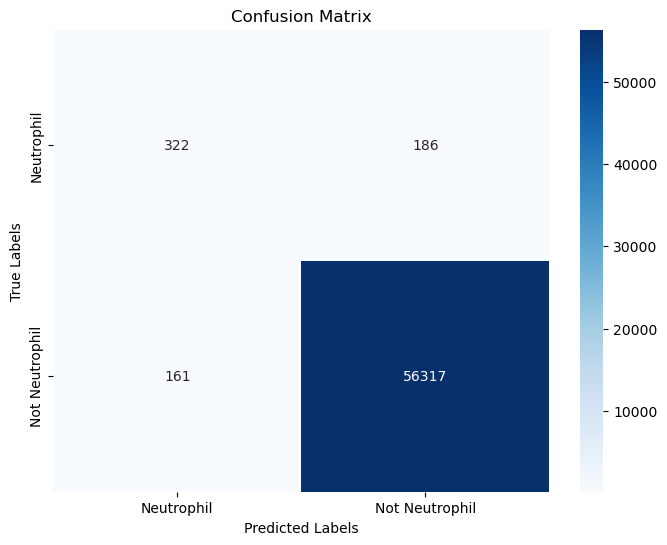

In [48]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Assuming cm is your confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutrophil', 'Not Neutrophil'], yticklabels=['Neutrophil', 'Not Neutrophil'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [50]:
# Load the test data (500/500)
test_data = datasets.ImageFolder(root='data/test', transform=data_module.transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        print(f'Accuracy of the model on the test images: {100 * correct / total}%')

Accuracy of the model on the test images: 65.625%
Accuracy of the model on the test images: 59.375%
Accuracy of the model on the test images: 55.208333333333336%
Accuracy of the model on the test images: 53.125%
Accuracy of the model on the test images: 58.125%
Accuracy of the model on the test images: 59.375%
Accuracy of the model on the test images: 57.589285714285715%
Accuracy of the model on the test images: 60.15625%
Accuracy of the model on the test images: 63.19444444444444%
Accuracy of the model on the test images: 63.125%
Accuracy of the model on the test images: 63.06818181818182%
Accuracy of the model on the test images: 62.239583333333336%
Accuracy of the model on the test images: 62.5%
Accuracy of the model on the test images: 61.607142857142854%
Accuracy of the model on the test images: 62.5%
Accuracy of the model on the test images: 63.671875%
Accuracy of the model on the test images: 65.80882352941177%
Accuracy of the model on the test images: 67.70833333333333%
Accurac

In [51]:
# Confusion matrix (500/50000)
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predictions
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

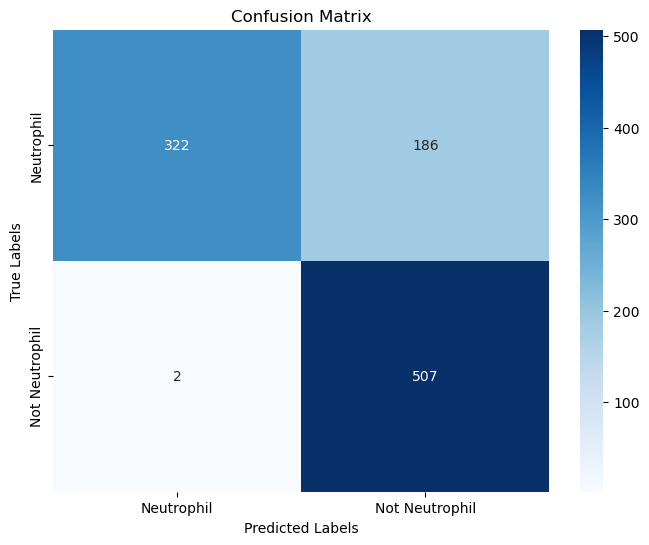

In [52]:
# Create the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Assuming cm is your confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutrophil', 'Not Neutrophil'], yticklabels=['Neutrophil', 'Not Neutrophil'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()